In [77]:
import torch
from torch import nn

import requests
import zipfile
from pathlib import Path

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import random
from PIL import Image

import os


torch.__version__

'2.7.1+cu118'

### Device agnostic code

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [12]:
data_path = Path("datasets/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():

    print(f"{image_path} directory exists")

else:

    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(image_path / "pizza_steak_sushi.zip", "wb") as f:

        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print(f"Downloading, pizza, steak, sushi data...")
        f.write(request.content)

with zipfile.ZipFile(image_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

datasets\pizza_steak_sushi directory exists
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

In [15]:
def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):

        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [16]:
walk_through_dir(image_path)

There are 2 directories and 1 images in datasets\pizza_steak_sushi
There are 3 directories and 0 images in datasets\pizza_steak_sushi\test
There are 0 directories and 25 images in datasets\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in datasets\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in datasets\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in datasets\pizza_steak_sushi\train
There are 0 directories and 78 images in datasets\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in datasets\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in datasets\pizza_steak_sushi\train\sushi


In [17]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('datasets/pizza_steak_sushi/train'),
 WindowsPath('datasets/pizza_steak_sushi/test'))

### Visualize an image

Random image path: datasets\pizza_steak_sushi\train\steak\560503.jpg
Image class: steak
height: 512 -- width: 512


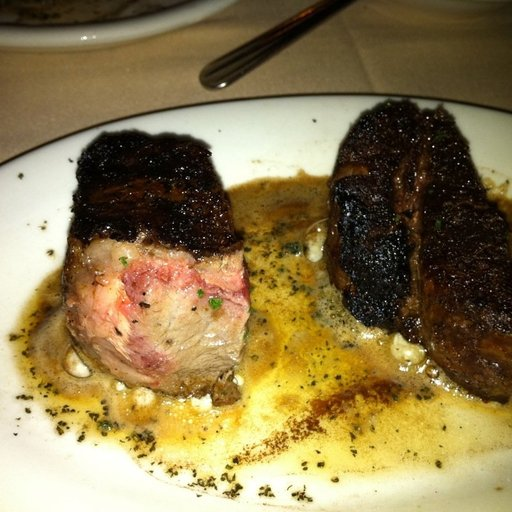

In [55]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"height: {img.height} -- width: {img.width}")
img

Image size: (512, 512)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

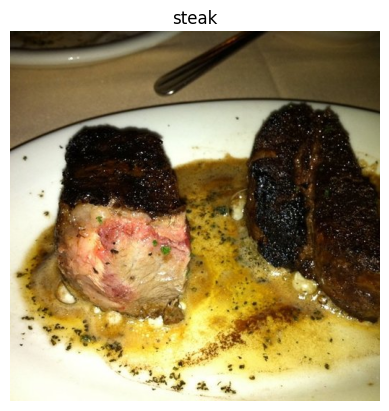

In [66]:
print(f"Image size: {img.size}")
plt.title(image_class)
plt.imshow(img)
plt.axis(False)

In [76]:
img_np = np.asarray(img)

img_np.shape

(512, 512, 3)

## 3. Transforming data

In [78]:
data_transform = transforms.Compose([

    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])